In [133]:
import pandas as pd
import numpy as np

# nltk  Libraries
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet

# Other Libraries
import random
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

from gensim.models import Word2Vec

In [109]:
def string_formatter(input_string):

    punctuation_list = list(string.punctuation)
    
    # Tokenize
    token_list = word_tokenize(input_string) 
    # Remove Stop Words
    # stop_words_removed = [word for word in token_list if word not in stopwords.words('english')] 
    # Remove Punctuation
    stop_words_punctuation_removed = [word for word in token_list if word not in punctuation_list] 
    # Put to Lower Case
    stop_words_punctuation_removed_case_folded = [word.lower() for word in stop_words_punctuation_removed] 
    # POS Tagged
    pos_tagged_words = nltk.pos_tag(stop_words_punctuation_removed_case_folded)

    # POS tags for wnl.lematize
    new_tags = [""] * len(pos_tagged_words)
    for i in range(len(pos_tagged_words)):
        if ((pos_tagged_words[i][1] == "VB") | (pos_tagged_words[i][1] == "VBG") |
            (pos_tagged_words[i][1] == "VBD") | (pos_tagged_words[i][1] == "VBN") |
            (pos_tagged_words[i][1] == "VBP") | (pos_tagged_words[i][1] == "VBZ")):
            new_tags[i] = wordnet.VERB
        elif ((pos_tagged_words[i][1] == "JJ") | (pos_tagged_words[i][1] == "JJR") |
              (pos_tagged_words[i][1] == "JJS")):
            new_tags[i] = wordnet.ADJ
        elif ((pos_tagged_words[i][1] == "RB") | (pos_tagged_words[i][1] == "RBR") |
              (pos_tagged_words[i][1] == "RBS") | (pos_tagged_words[i][1] == "WRB")):
            new_tags[i] = wordnet.ADV
        else:
            new_tags[i] = wordnet.NOUN

    # Lemmatization
    wnl = WordNetLemmatizer()
    lemma_words = [""] * len(stop_words_punctuation_removed_case_folded)
    for i in range(len(stop_words_punctuation_removed_case_folded)):
        lemma_words[i] = wnl.lemmatize(stop_words_punctuation_removed_case_folded[i], pos = new_tags[i])

    return " ".join(lemma_words)

In [110]:
sentimentsOfArticles = pd.read_json("DataCollectionAndFormatting/sentimentsOfArticles.json")
sentimentsOfArticles.head()

,Link,Date,Text,Sentiments
0,https://www.investing.com/news/stock-market-ne...,2023-12-04,"Company OverviewEnphase Energy, Inc. (NASDAQ:E...",NEUTRAL
1,https://www.investing.com/news/stock-market-ne...,2023-12-04,SolarEdge Technologies (NASDAQ:SEDG) Inc. has ...,NEUTRAL
2,https://www.investing.com/news/stock-market-ne...,2023-12-04,"In the dynamic world of technology, Apple Inc ...",NEUTRAL
3,https://www.investing.com/news/stock-market-ne...,2023-12-10,By Anirban Sen (Reuters) - U.S. health insurer...,NEGATIVE
4,https://www.investing.com/news/stock-market-ne...,2023-12-04,In the dynamic landscape of software and digit...,POSITIVE


In [111]:
formatted_text = [string_formatter(article) for article in sentimentsOfArticles["Text"]]
formatted_text[:5]

["company overviewenphase energy inc. nasdaq enph a key player in the energy management solution space be know for it solar microinverters home energy storage and web-based monitoring and control the company have make a name for itself with it inverter system which have be integral to it rapid growth operate within the north america clean technology sector enphase have expand it presence to over 130 country and have product deploy at more than 1.5 million customer sites.market performance and strategyanalysts have be scrutinize enphase 's performance amidst a challenging macroeconomic environment mark by high interest rate and a solar industry face sluggish demand the company 's weak revenue guidance for the upcoming quarter reflect the impact of destocking issue and a demand downturn particularly in europe despite these headwind enphase 's management be confident in the company 's ability to maintain it u.s. inverter market share even against new entrant like tesla nasdaq tsla the com

In [112]:
X_train, X_test, y_train, y_test = train_test_split(formatted_text, sentimentsOfArticles["Sentiments"], test_size = 0.2, random_state = 8972394)

### Model 1: TF-IDF Matrix

In [113]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, random_state=8972394)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

Accuracy: 0.7412790697674418


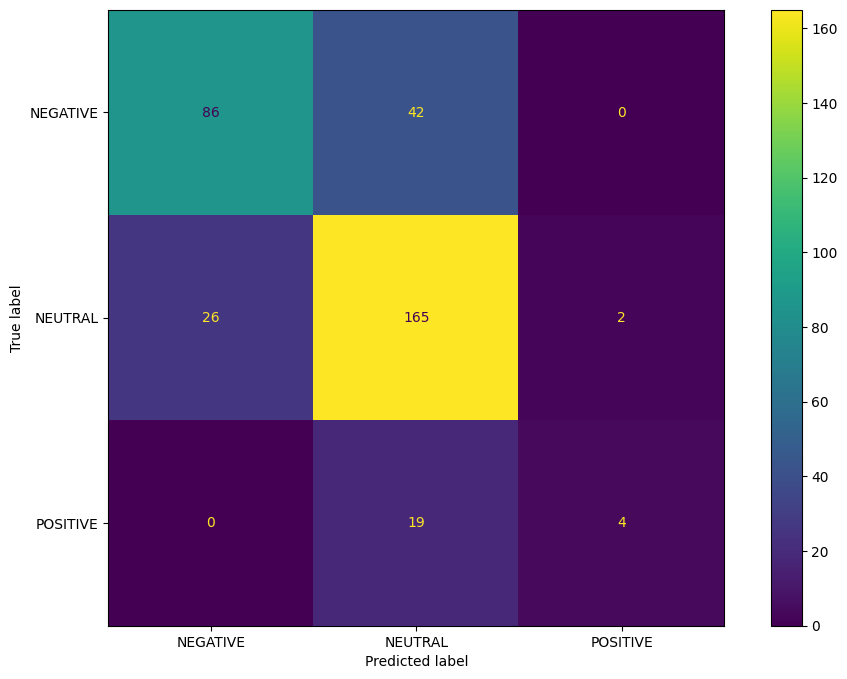

In [114]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

fig, ax = plt.subplots(figsize=(12,8))
conf_mat_tfidf = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_mat_tfidf, display_labels = list(set(y_pred))).plot(ax = ax);

### Model 2: Word2Vec 

In [166]:
size = 100
tokenized_sentences_train = [word_tokenize(sentence) for sentence in X_train]
w2v_model = Word2Vec(sentences=tokenized_sentences_train, vector_size=size, window=5, min_count=1, workers=4)
X_train_word2vec = []
for tokened_sentence in tokenized_sentences_train:
    num_words = len(tokened_sentence)
    sentence_vector = np.zeros(size)
    for word in tokened_sentence:
        try:
            word_vector = model.wv[word]
            sentence_vector += word_vector
        except:
            continue
    sentence_vector /= num_words
    X_train_word2vec.append(sentence_vector)

tokenized_sentences_test = [word_tokenize(sentence) for sentence in X_test]
X_test_word2vec = []
for tokened_sentence in tokenized_sentences_test:
    num_words = len(tokened_sentence)
    sentence_vector = np.zeros(size)
    for word in tokened_sentence:
        try:
            word_vector = model.wv[word]
            sentence_vector += word_vector
        except:
            continue
    sentence_vector /= num_words
    X_test_word2vec.append(sentence_vector)

In [169]:
clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, random_state=8972394)
clf.fit(X_train_word2vec, y_train)
y_pred = clf.predict(X_test_word2vec)

Accuracy: 0.7325581395348837


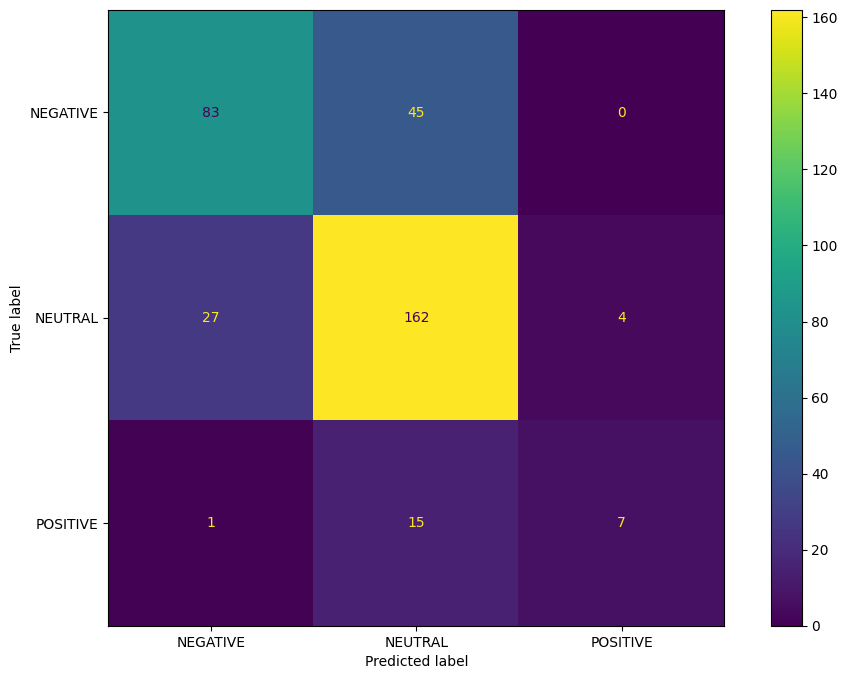

In [170]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

fig, ax = plt.subplots(figsize=(12,8))
conf_mat_tfidf = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_mat_tfidf, display_labels = list(set(y_pred))).plot(ax = ax);